In [1]:
# Part 1: LCC based layer selection
library(InfoWalkR)
library(ggplot2)
library(tidyr)
library(igraph)
library(dplyr)

Warning message:
“vorhergehender Import ‘gridExtra::combine’ durch ‘dplyr::combine’ während des Ladens von ‘InfoWalkR’ ersetzt”
Warning message:
“vorhergehender Import ‘dplyr::as_data_frame’ durch ‘igraph::as_data_frame’ während des Ladens von ‘InfoWalkR’ ersetzt”
Warning message:
“vorhergehender Import ‘dplyr::groups’ durch ‘igraph::groups’ während des Ladens von ‘InfoWalkR’ ersetzt”
Warning message:
“vorhergehender Import ‘dplyr::union’ durch ‘igraph::union’ während des Ladens von ‘InfoWalkR’ ersetzt”

Attache Paket: ‘igraph’


Das folgende Objekt ist maskiert ‘package:tidyr’:

    crossing


Die folgenden Objekte sind maskiert von ‘package:stats’:

    decompose, spectrum


Das folgende Objekt ist maskiert ‘package:base’:

    union



Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:igraph’:

    as_data_frame, groups, union


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:


In [20]:
#read in Network
path <- "/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/Data/raw/multiplex_InfoWalkR/"
graph_list = read_graphs_from_folder(path)

graph_list
#remove layers:
graph_list$coex_ITI <- NULL
graph_list$coex_LVR <- NULL
graph_list$coex_MSG <- NULL
graph_list$coex_LCL <- NULL
graph_list$coex_UTR <- NULL
graph_list$reactome_copathway <- NULL

graph_list 

$`co-essential`
IGRAPH d4cc72e UN-- 3483 68813 -- 
+ attr: name (v/c)
+ edges from d4cc72e (vertex names):
 [1] TSC1     --TSC2     NDUFA8   --NDUFS5   ATIC     --PAICS   
 [4] TADA1    --TAF5L    NDUFA8   --NDUFV2   TADA2B   --TAF5L   
 [7] EARS2    --MRPS6    SUPT20H  --TAF5L    TADA1    --SUPT20H 
[10] MRPS6    --MRPS24   MRPS6    --MRPL43   CAD      --UMPS    
[13] KIDINS220--XPR1     EARS2    --LARS2    NDUFS1   --NDUFS5  
[16] TADA2B   --SUPT20H  EARS2    --TWNK     GART     --PAICS   
[19] NDUFC1   --NDUFV2   NDUFB3   --NDUFS5   FARS2    --LARS2   
[22] NDUFA8   --NDUFA11  MARS2    --MRPS11   UBA5     --UFM1    
+ ... omitted several edges

$coex_ADS
IGRAPH 9bcc701 UN-- 7737 66738 -- 
+ attr: name (v/c)
+ edges from 9bcc701 (vertex names):
 [1] POLDIP2 --HCCS     KLHL13  --TSPOAP1  POLDIP2 --GDE1     ARHGAP33--REX1BD  
 [5] WDR54   --OSBPL7   KDM7A   --IFRD1    AK2     --COX10    TSPOAP1 --ARHGAP44
 [9] KIAA0100--NADK     KLHL13  --ADAM22   TMEM98  --CYB561   GAS7    --CYB561  


$`co-essential`
IGRAPH d4cc72e UN-- 3483 68813 -- 
+ attr: name (v/c)
+ edges from d4cc72e (vertex names):
 [1] TSC1     --TSC2     NDUFA8   --NDUFS5   ATIC     --PAICS   
 [4] TADA1    --TAF5L    NDUFA8   --NDUFV2   TADA2B   --TAF5L   
 [7] EARS2    --MRPS6    SUPT20H  --TAF5L    TADA1    --SUPT20H 
[10] MRPS6    --MRPS24   MRPS6    --MRPL43   CAD      --UMPS    
[13] KIDINS220--XPR1     EARS2    --LARS2    NDUFS1   --NDUFS5  
[16] TADA2B   --SUPT20H  EARS2    --TWNK     GART     --PAICS   
[19] NDUFC1   --NDUFV2   NDUFB3   --NDUFS5   FARS2    --LARS2   
[22] NDUFA8   --NDUFA11  MARS2    --MRPS11   UBA5     --UFM1    
+ ... omitted several edges

$coex_ADS
IGRAPH 9bcc701 UN-- 7737 66738 -- 
+ attr: name (v/c)
+ edges from 9bcc701 (vertex names):
 [1] POLDIP2 --HCCS     KLHL13  --TSPOAP1  POLDIP2 --GDE1     ARHGAP33--REX1BD  
 [5] WDR54   --OSBPL7   KDM7A   --IFRD1    AK2     --COX10    TSPOAP1 --ARHGAP44
 [9] KIAA0100--NADK     KLHL13  --ADAM22   TMEM98  --CYB561   GAS7    --CYB561  


In [3]:
# load seed genes
gene_set <- readLines("/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/Data/raw/disease_genes.txt")


In [4]:
# show function of infowalk package
lcc_based_network_selection

function (graph_list, gene_set, trial = 1000, randomization = "dpr_binned", 
    alpha = 0.05) 
{
    results = list()
    for (graph_name in names(graph_list)) {
        graph = graph_list[[graph_name]]
        observed_lcc_size = calculate_lcc(graph, gene_set)
        lcc_size_distribution = calc_lcc_distribution_random_expectation(graph, 
            gene_set, trial, randomization)
        mean_lcc = mean(lcc_size_distribution)
        sd_lcc = sd(lcc_size_distribution)
        z_score = (observed_lcc_size - mean_lcc)/sd_lcc
        p_value = 1 - pnorm(z_score)
        clean_graph_name = gsub(".tsv$", "", graph_name)
        results[[clean_graph_name]] = list(lcc_size_distribution = lcc_size_distribution, 
            observed_lcc_size = observed_lcc_size, mean_lcc = mean_lcc, 
            sd_lcc = sd_lcc, z_score = z_score, p_value = p_value)
    }
    results_df = convert_results_to_df(results)
    results_df = filter_for_sig_layer_results(results_df, alpha)
    significant_layers = pull_significant_layers(results_df, 
        alpha, graph_list)
    return(list(results = results_df, significant_networks = significant_layers))
}
<bytecode: 0x10f8b27b8>
<environment: namespace:InfoWalkR>

In [5]:
#Adaptation of the lcc_based_network_selection function
lcc_based_network_selection_adapted = function (graph_list, gene_set, trial = 1000, randomization = "dpr_binned", 
    alpha = 0.05) 
{
    results = list()
    for (graph_name in names(graph_list)) {
        graph = graph_list[[graph_name]]
        observed_lcc_size = calculate_lcc(graph, gene_set)
        lcc_size_distribution = calc_lcc_distribution_random_expectation(graph, 
            gene_set, trial, randomization)
        mean_lcc = mean(lcc_size_distribution)
        sd_lcc = sd(lcc_size_distribution)
        z_score = (observed_lcc_size - mean_lcc)/sd_lcc
        p_value = 1 - pnorm(z_score)
        clean_graph_name = gsub(".tsv$", "", graph_name)
        results[[clean_graph_name]] = list(lcc_size_distribution = lcc_size_distribution, 
            observed_lcc_size = observed_lcc_size, mean_lcc = mean_lcc, 
            sd_lcc = sd_lcc, z_score = z_score, p_value = p_value)
    }
    results_df = convert_results_to_df(results) 
    results_df_filtered = filter_for_sig_layer_results(results_df, alpha) #here adapted
    significant_layers = pull_significant_layers(results_df_filtered, 
        alpha, graph_list)
    return(list(results = results_df, results_filtered = results_df_filtered, significant_networks = significant_layers)) #here adapted
}

In [6]:
# perform layer selection based on lcc that seed genes form
lcc_results = lcc_based_network_selection_adapted(graph_list, gene_set,
                                          trial = 1500, randomization = 'random',
                                          alpha = 0.05)


In [7]:
#save results
saveRDS(object = lcc_results,file = "/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/results/lcc_res")

In [2]:
#pull results
lcc_results<- readRDS(file = "/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/results/lcc_res")
head(lcc_results$results)
nrow(lcc_results$results)
df = lcc_results$results


,network_name,lcc_size_distribution,observed_lcc_size,mean_lcc_size,sd_lcc,z_score,p_value
,<chr>,<I<list>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,co-essential,"1, 1, 1,....",2,1.216667,0.4780599,1.6385674,0.05065169
2,coex_ADS,"1, 1, 1,....",1,1.224667,0.4729419,-0.4750408,0.68262104
3,coex_ADV,"1, 2, 1,....",2,1.878000,0.8799425,0.1386454,0.44486518
4,coex_ARG,"1, 2, 2,....",3,2.240667,0.9490416,0.8001054,0.21182487
5,coex_ATA,"1, 1, 1,....",1,1.214000,0.4460979,-0.4797153,0.68428509
6,coex_ATC,"3, 2, 2,....",1,2.056000,0.8579169,-1.2308885,0.89081771


[1] 66

In [3]:
# Prepare Data for plotting
# for histogram showing LCC for random genes
hist_df <- do.call(rbind, lapply(seq_len(nrow(df)), function(i) {
  data.frame(
    network_name = df$network_name[i],
    value = df$lcc_size_distribution[[i]]
  )
}))



In [4]:
# Prepare Data for plotting
# fitting normal distribution 
norm_df <- do.call(rbind, lapply(seq_len(nrow(df)), function(i) {

  mu <- df$mean_lcc_size[i]
  sd <- df$sd_lcc[i]

  x <- seq(mu - 4 * sd, mu + 4 * sd, length.out = 200) # Create the x-axis range

  data.frame(
    network_name = df$network_name[i],
    x = x,
    y = dnorm(x, mean = mu, sd = sd) # Calculate the normal distribution values
  )
}))


In [5]:
# calculate significance border
 
alpha_df <- data.frame(
  network_name = df$network_name,
  alpha_05 = df$mean_lcc_size + qnorm(0.95) * df$sd_lcc,
  alpha_01 = df$mean_lcc_size + qnorm(0.99) * df$sd_lcc
)
head(alpha_df)


,network_name,alpha_05,alpha_01
,<chr>,<dbl>,<dbl>
1,co-essential,2.003005,2.328800
2,coex_ADS,2.002587,2.324894
3,coex_ADV,3.325377,3.925052
4,coex_ARG,3.801701,4.448468
5,coex_ATA,1.947766,2.251779
6,coex_ATC,3.467148,4.051813


In [6]:
# prepare for plotting
alpha_long <- rbind(
  data.frame(
    network_name = alpha_df$network_name,
    alpha = "0.05",
    x = alpha_df$alpha_05
  ),
  data.frame(
    network_name = alpha_df$network_name,
    alpha = "0.01",
    x = alpha_df$alpha_01
  )
)
head(alpha_long)

,network_name,alpha,x
,<chr>,<chr>,<dbl>
1,co-essential,0.05,2.003005
2,coex_ADS,0.05,2.002587
3,coex_ADV,0.05,3.325377
4,coex_ARG,0.05,3.801701
5,coex_ATA,0.05,1.947766
6,coex_ATC,0.05,3.467148


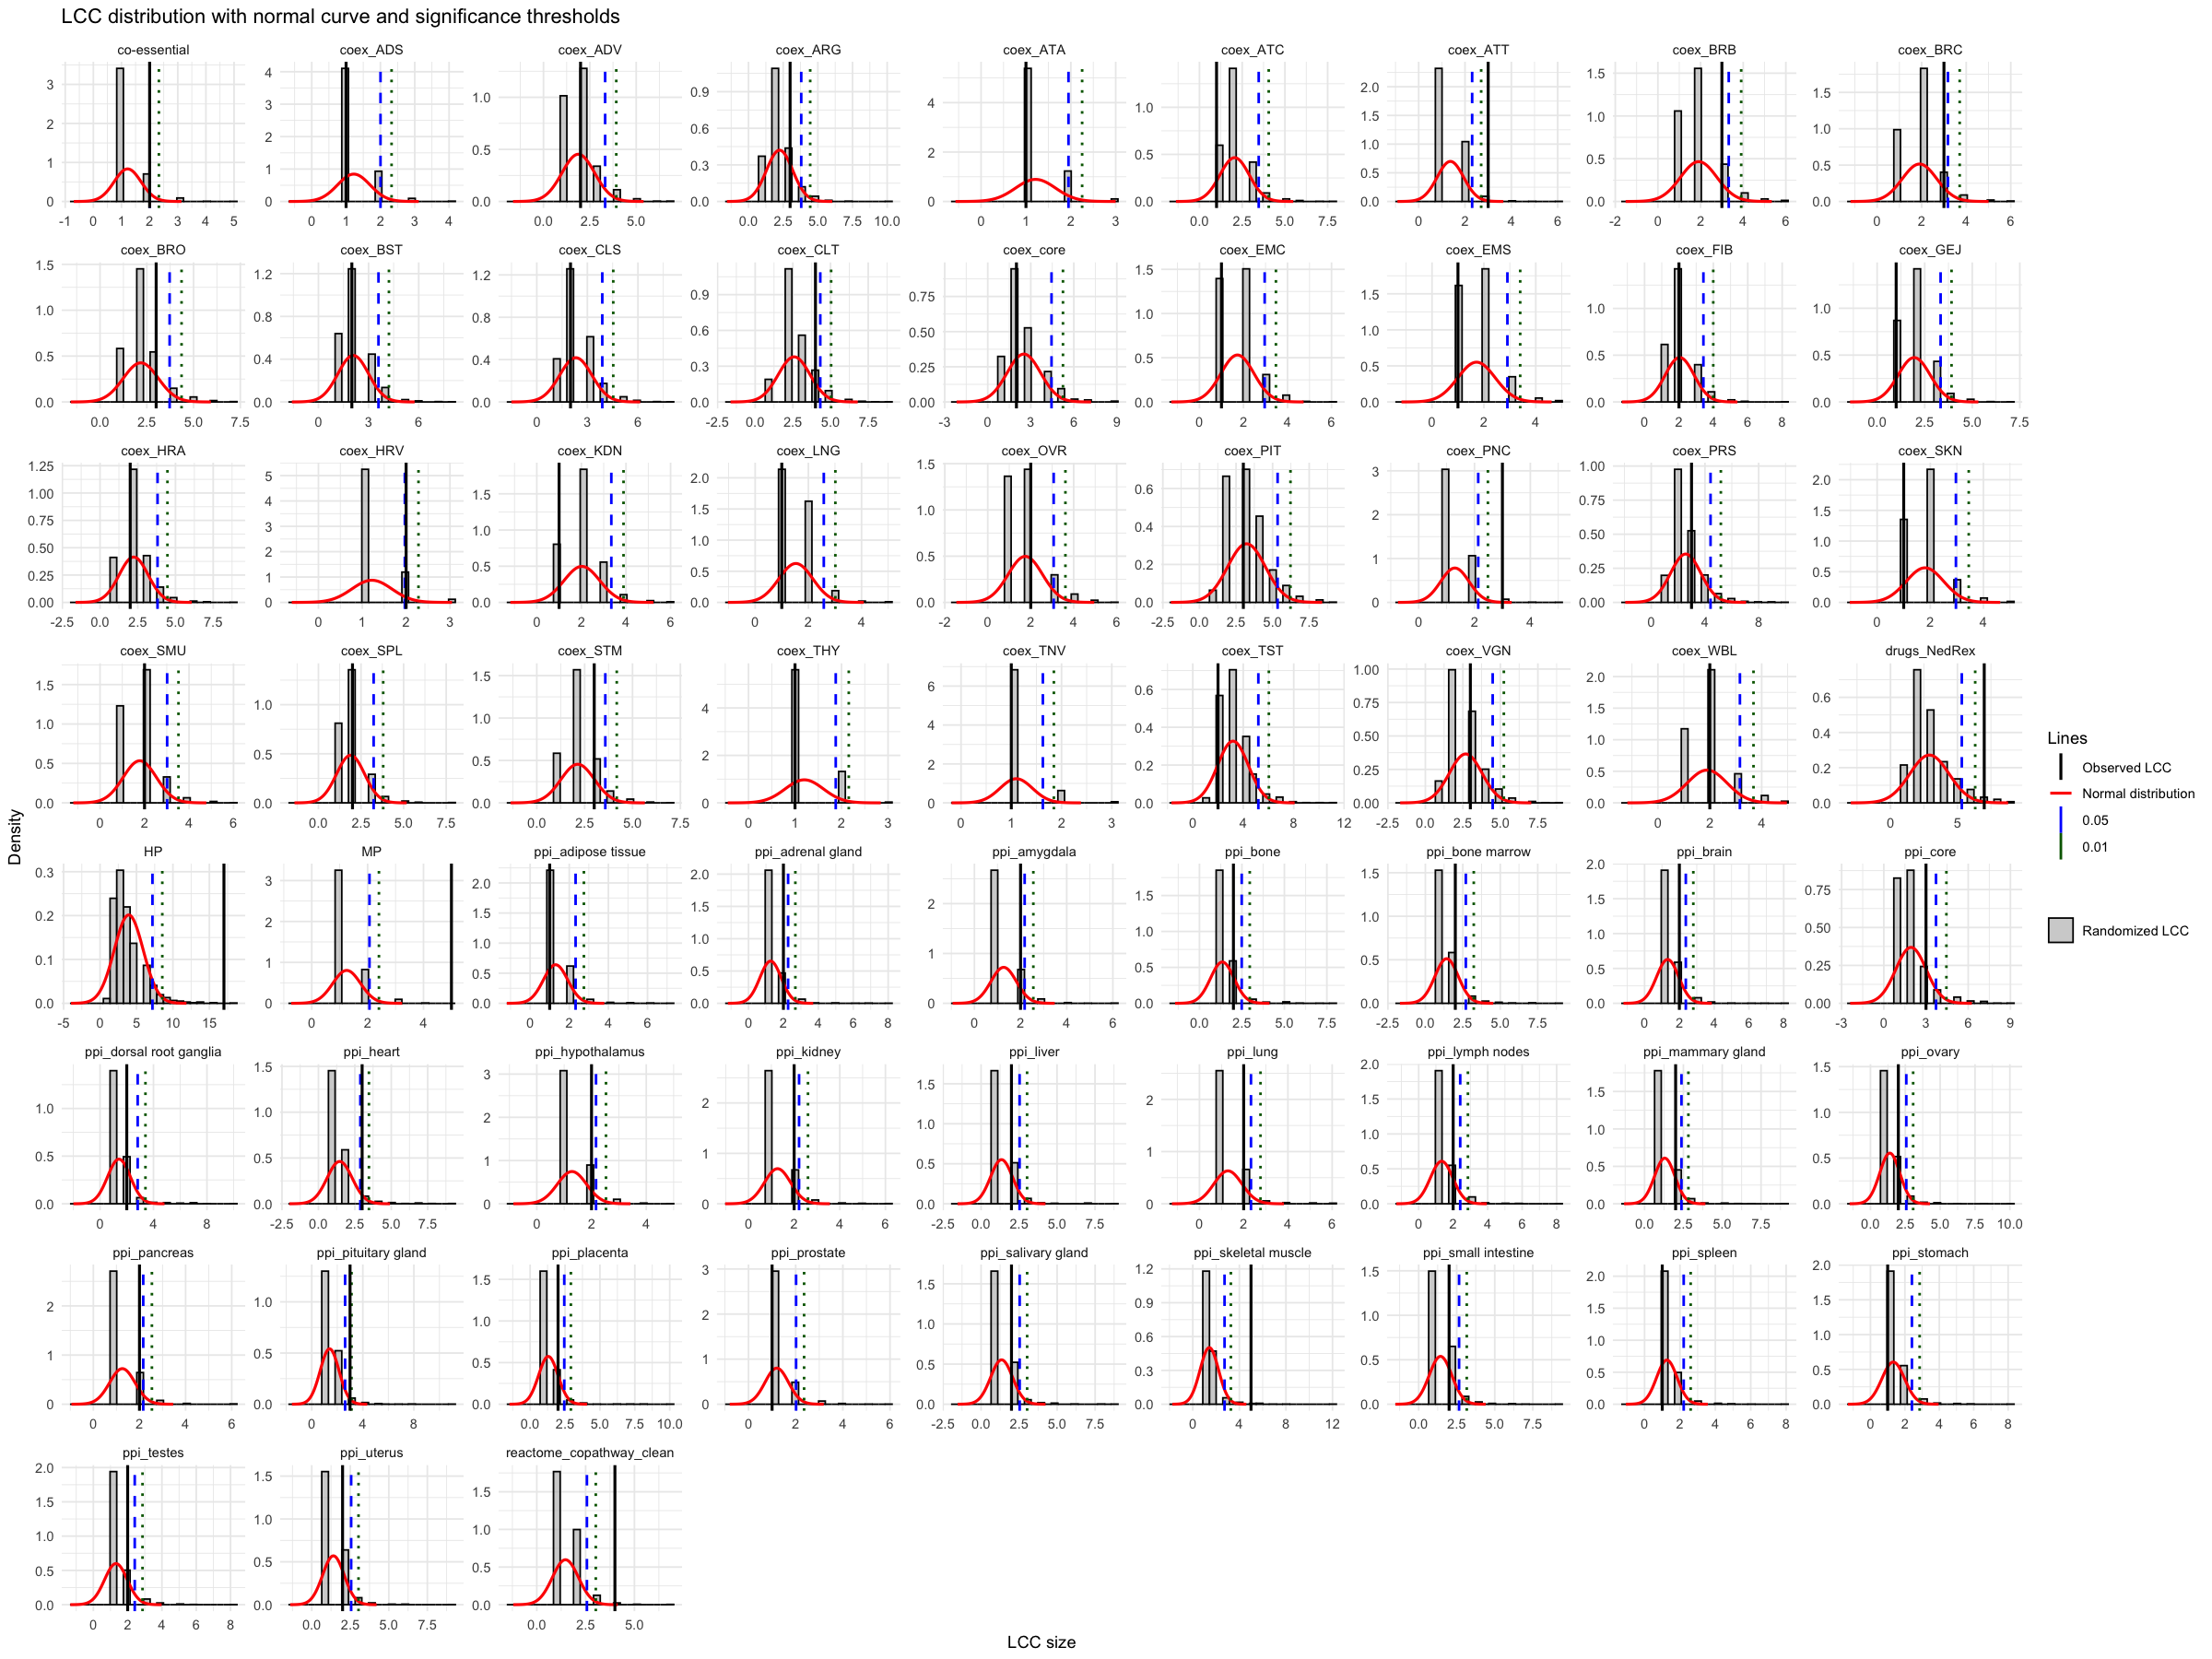

In [7]:
options(repr.plot.width=20, repr.plot.height=15)
ggplot(hist_df, aes(x = value)) +

  # histogram: randomized LCC
  geom_histogram(
    aes(y = after_stat(density), fill = "Randomized LCC"),
    bins = 25,
    color = "black",
    alpha = 0.6
  ) +

  # normaldistribution 
  geom_line(
    data = norm_df,
    aes(x = x, y = y, color = "Normal distribution"),
    linewidth = 0.9
  ) +

  # significance border
  geom_vline(
    data = alpha_long,
    aes(xintercept = x, linetype = alpha, color = alpha),
    linewidth = 0.8
  ) +

  # observed LCC
  geom_vline(
    data = df,
    aes(xintercept = observed_lcc_size, color = "Observed LCC"),
    linewidth = 0.9
  ) +

  facet_wrap(~ network_name, scales = "free") +

  # explain colors
  scale_color_manual(
    name = "Lines",
    values = c(
      "Normal distribution" = "red",
      "Observed LCC" = "black",
      "0.05" = "blue",
      "0.01" = "darkgreen"
    ),
    breaks = c("Observed LCC", "Normal distribution", "0.05", "0.01")
  ) +

  # linetypes for α 
  scale_linetype_manual(
    values = c("0.05" = "dashed", "0.01" = "dotted")
  ) +

  # legend for histogram
  scale_fill_manual(
    name = "",
    values = c("Randomized LCC" = "grey70")
  ) +

 
  guides(linetype = "none") +

  theme_minimal() +
  theme(
    legend.position = "right",
    legend.box = "vertical"
  )+
  labs(
    x = "LCC size",
    y = "Density",
    title = "LCC distribution with normal curve and significance thresholds"
  )


In [14]:
 ggsave(
  "results/lcc_histogram_normal_grid.pdf",
  width = 16,
  height = 12
)

In [8]:
# calculate significance borders with Bonferroni correction
alpha_df <- data.frame(
  network_name = df$network_name,

  alpha_05_bonf = df$mean_lcc_size +
    qnorm(1 - 0.05 / nrow(df)) * df$sd_lcc,

  alpha_01_bonf = df$mean_lcc_size +
    qnorm(1 - 0.01 / nrow(df)) * df$sd_lcc
)


In [9]:
# prepare for plotting
alpha_long <- rbind(
  data.frame(
    network_name = alpha_df$network_name,
    alpha = "0.05 (Bonf.)",
    x = alpha_df$alpha_05_bonf
  ),
  data.frame(
    network_name = alpha_df$network_name,
    alpha = "0.01 (Bonf.)",
    x = alpha_df$alpha_01_bonf
  )
)


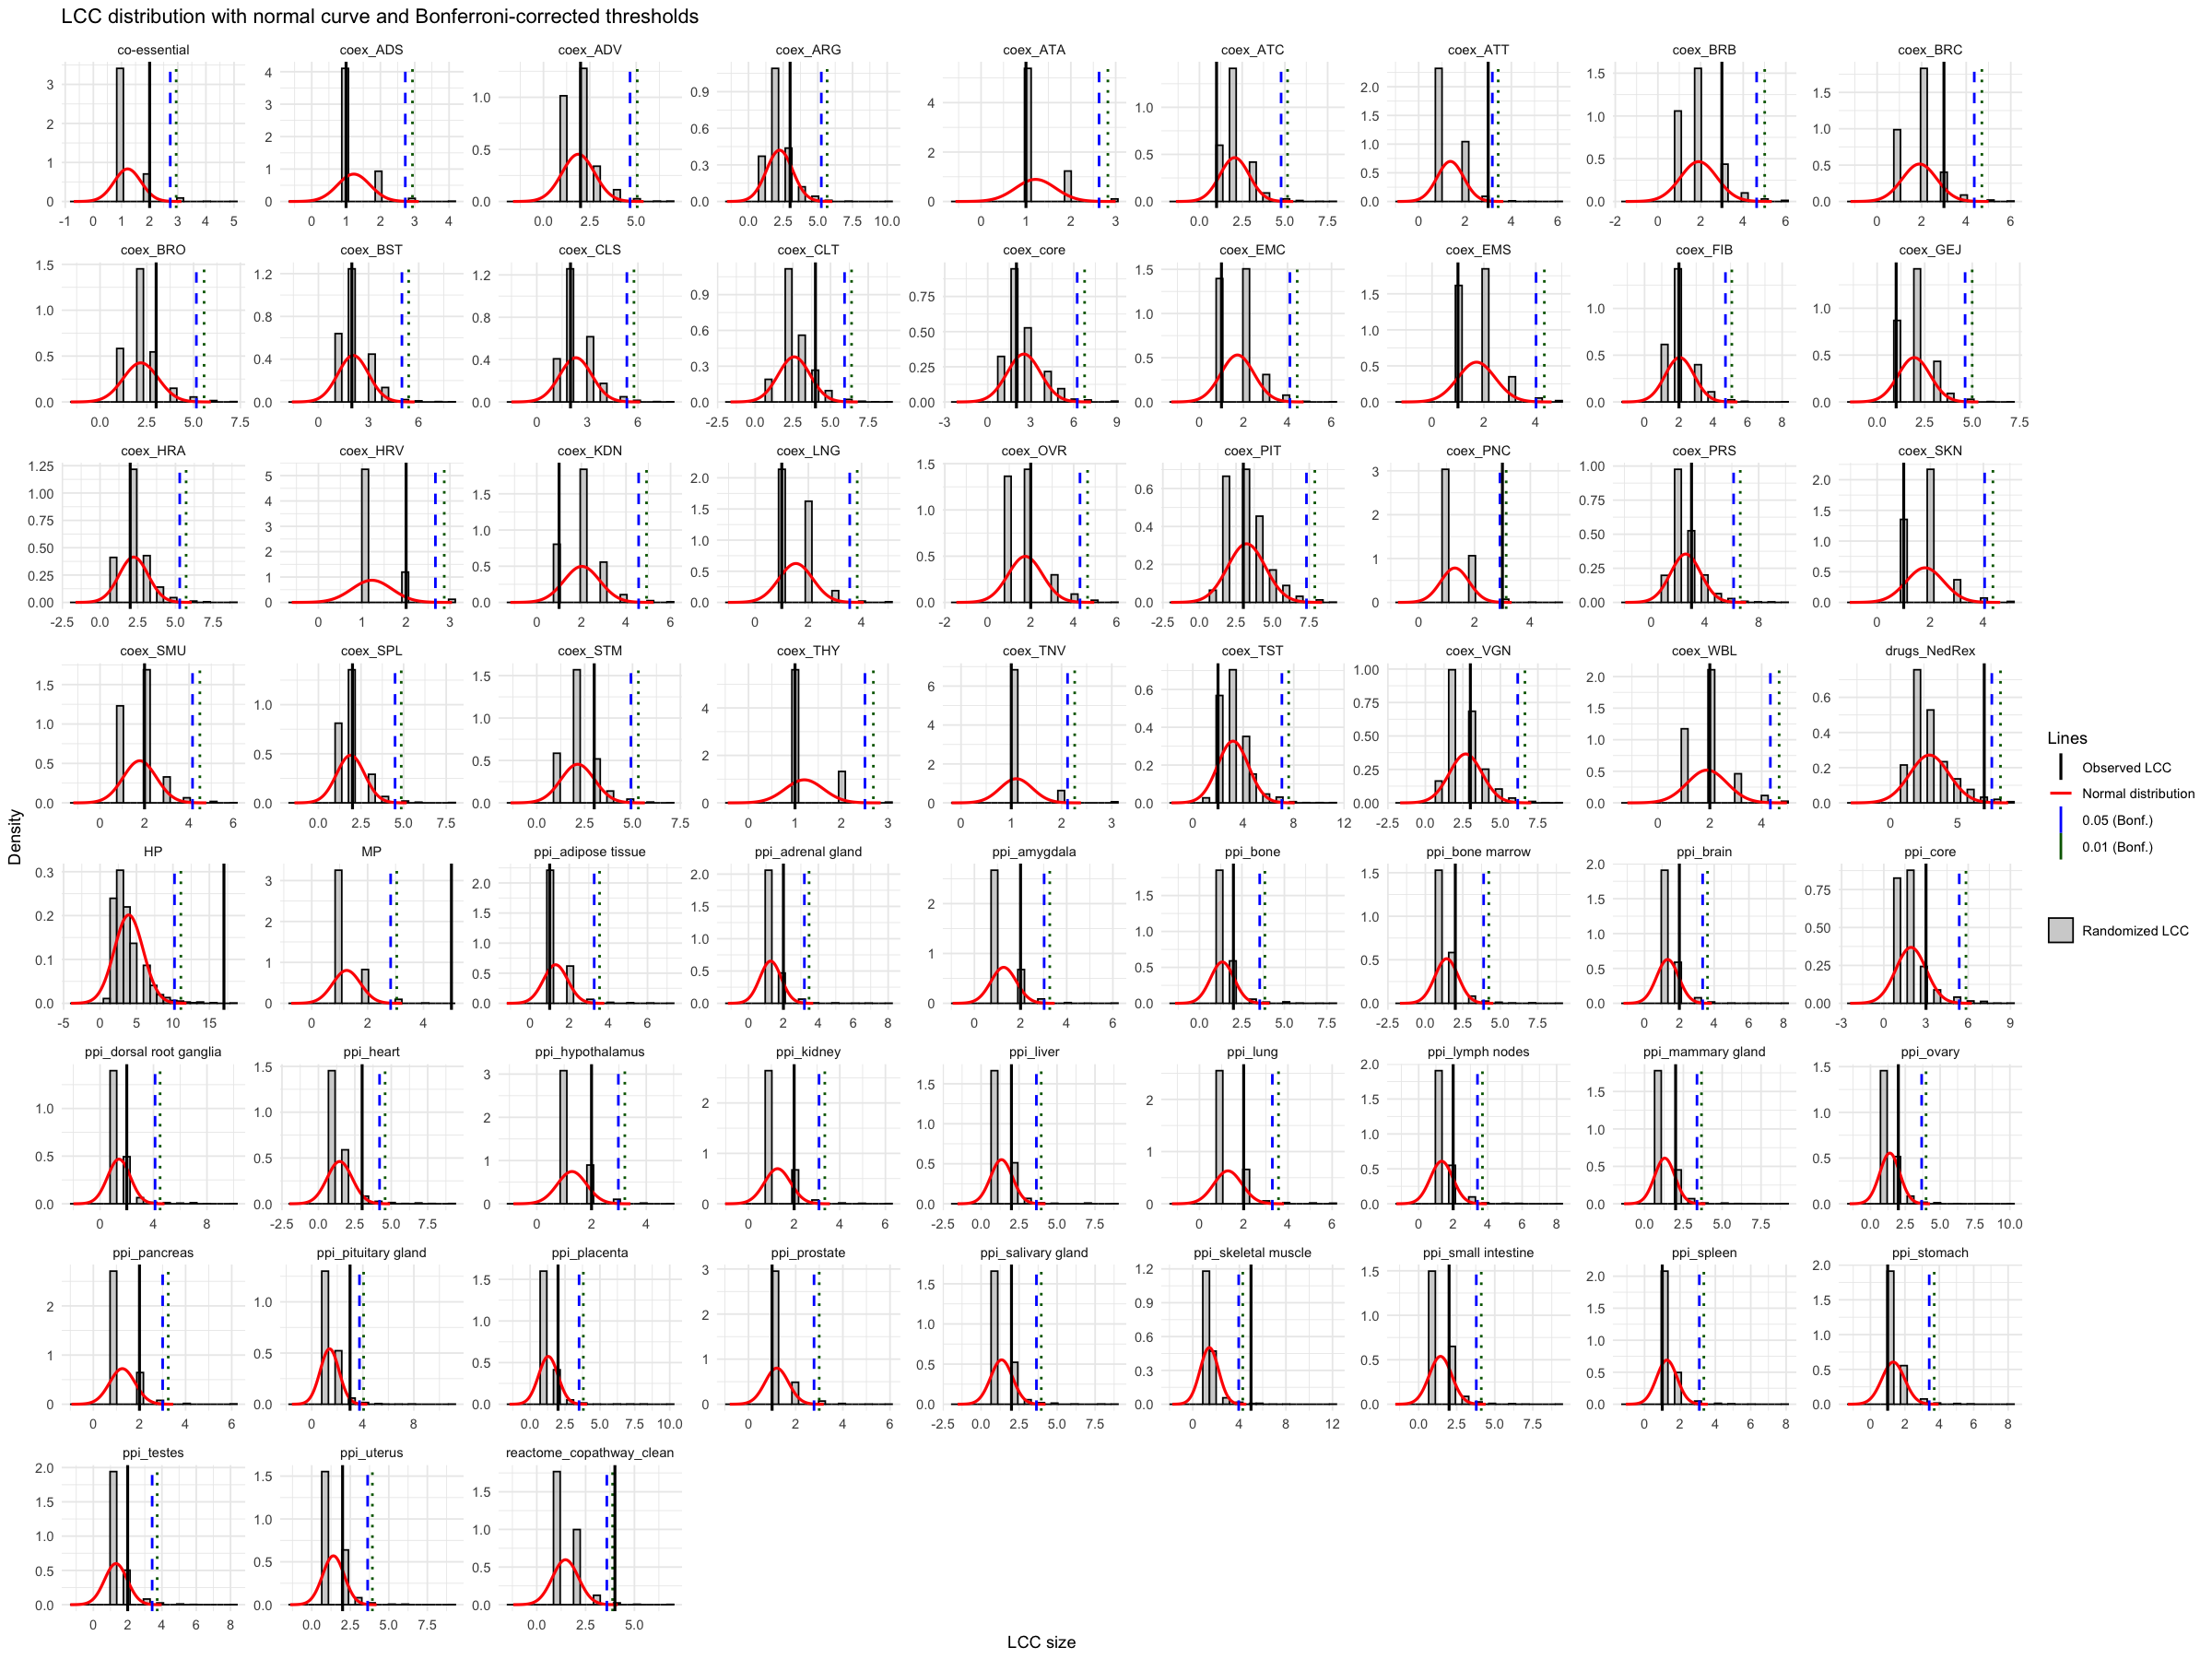

In [10]:
options(repr.plot.width=20, repr.plot.height=15)
ggplot(hist_df, aes(x = value)) +

  # histogram: randomized LCC
  geom_histogram(
    aes(y = after_stat(density), fill = "Randomized LCC"),
    bins = 25,
    color = "black",
    alpha = 0.6
  ) +

  # normaldistribution 
  geom_line(
    data = norm_df,
    aes(x = x, y = y, color = "Normal distribution"),
    linewidth = 0.9
  ) +

  # Bonferroni significance borders
  geom_vline(
    data = alpha_long,
    aes(xintercept = x, linetype = alpha, color = alpha),
    linewidth = 0.8
  ) +

  # observed LCC
  geom_vline(
    data = df,
    aes(xintercept = observed_lcc_size, color = "Observed LCC"),
    linewidth = 0.9
  ) +

  facet_wrap(~ network_name, scales = "free") +

  # explain colors
  scale_color_manual(
    name = "Lines",
    values = c(
      "Normal distribution" = "red",
      "Observed LCC" = "black",
      "0.05 (Bonf.)" = "blue",
      "0.01 (Bonf.)" = "darkgreen"
    ),
    breaks = c(
      "Observed LCC",
      "Normal distribution",
      "0.05 (Bonf.)",
      "0.01 (Bonf.)"
    )
  ) +

  # linetypes
  scale_linetype_manual(
    values = c(
      "0.05 (Bonf.)" = "dashed",
      "0.01 (Bonf.)" = "dotted"
    )
  ) +

  # histogram legend
  scale_fill_manual(
    name = "",
    values = c("Randomized LCC" = "grey70")
  ) +

  
  guides(linetype = "none") +

  theme_minimal() +
  theme(
    legend.position = "right",
    legend.box = "vertical"
  ) +
  labs(
    x = "LCC size",
    y = "Density",
    title = "LCC distribution with normal curve and Bonferroni-corrected thresholds"
  )


In [18]:
 ggsave(
  "results/lcc_histogram_normal_grid_bonf.pdf",
  width = 16,
  height = 12
)

In [11]:
# calculate alpha after bonferroni correction
alpha_bonf_0.05 <- 0.05/nrow(df)
alpha_bonf_0.01 <- 0.01/nrow(df)

In [12]:
# test where the p value is lower than corrected alpha 
# filter (p < Bonferroni-α)
df_sig_bonf_005 <- df[df$p_value < alpha_bonf_0.05, ]
df_sig_bonf_001 <- df[df$p_value < alpha_bonf_0.01, ]
df_sig_bonf_005 
df_sig_bonf_001 
df_to_save <- df_sig_bonf_005
df_to_save$lcc_size_distribution <- NULL
write.csv(df_to_save,
          file = "results/lcc_significant_layers_bonferroni_005.csv")

,network_name,lcc_size_distribution,observed_lcc_size,mean_lcc_size,sd_lcc,z_score,p_value
,<chr>,<I<list>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
25,coex_PNC,"4, 1, 2,....",3,1.296000,0.5091399,3.346820,4.087206e-04
37,HP,"6, 2, 4,....",17,3.935333,1.9806818,6.596045,2.111356e-11
38,MP,"1, 2, 1,....",5,1.250000,0.4963173,7.555650,2.087219e-14
60,ppi_skeletal muscle,"2, 2, 1,....",5,1.420667,0.7950646,4.501941,3.366791e-06
66,reactome_copathway_clean,"1, 1, 1,....",4,1.466667,0.6682214,3.791158,7.497315e-05


,network_name,lcc_size_distribution,observed_lcc_size,mean_lcc_size,sd_lcc,z_score,p_value
,<chr>,<I<list>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
37,HP,"6, 2, 4,....",17,3.935333,1.9806818,6.596045,2.111356e-11
38,MP,"1, 2, 1,....",5,1.250000,0.4963173,7.555650,2.087219e-14
60,ppi_skeletal muscle,"2, 2, 1,....",5,1.420667,0.7950646,4.501941,3.366791e-06
66,reactome_copathway_clean,"1, 1, 1,....",4,1.466667,0.6682214,3.791158,7.497315e-05


In [13]:
# export df of sig layers ( cols network_name & z_score)
df_sig<- df_sig_bonf_005[,c("network_name","z_score")]

write.csv(
  df_sig, 
  file = "/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/results/lcc_sig_layer.csv",
  row.names = FALSE
)

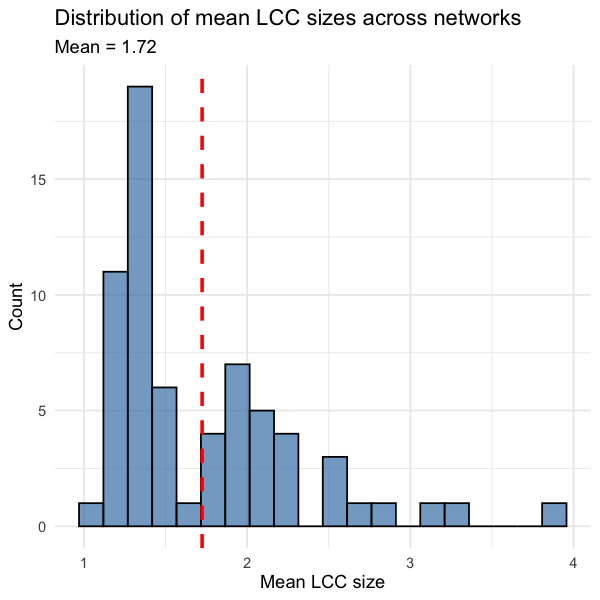

In [14]:
# plot distribution of the means  
options(repr.plot.width=5, repr.plot.height=5)
ggplot(df, aes(x = mean_lcc_size)) +
  geom_histogram(bins = 20, fill = "steelblue", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean(mean_lcc_size)), 
             color = "red", linetype = "dashed", linewidth = 1) +
  theme_minimal() +
  labs(
    x = "Mean LCC size",
    y = "Count",
    title = "Distribution of mean LCC sizes across networks",
    subtitle = paste("Mean =", round(mean(df$mean_lcc_size), 2))
  )
 ggsave(
  "results/dist_mean_LCC.pdf",
  width = 5,
  height = 5
)

In [15]:
# fit normal distribution to mean distribution
mean_lcc_vec <- df$mean_lcc_size

mu_means <- mean(mean_lcc_vec, na.rm = TRUE)
sd_means <- sd(mean_lcc_vec, na.rm = TRUE)

norm_df_means <- data.frame(
  x = seq(
    mu_means - 4 * sd_means,
    mu_means + 4 * sd_means,
    length.out = 300
  )
)
norm_df_means$y <- dnorm(norm_df_means$x, mean = mu_means, sd = sd_means)


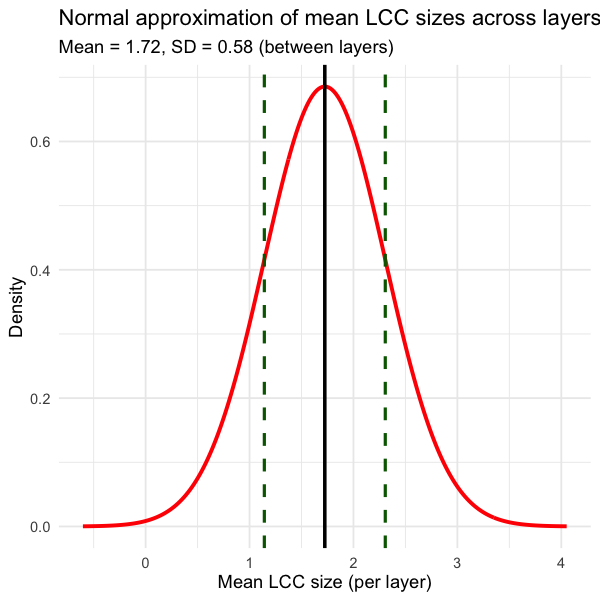

In [16]:
ggplot(norm_df_means, aes(x = x, y = y)) +

  geom_line(
    color = "red",
    linewidth = 1.1
  ) +

  # mean
  geom_vline(
    xintercept = mu_means,
    color = "black",
    linewidth = 1
  ) +

  # ±1 SD
  geom_vline(
    xintercept = c(mu_means - sd_means, mu_means + sd_means),
    linetype = "dashed",
    color = "darkgreen",
    linewidth = 0.9
  ) +

  theme_minimal() +
  labs(
    x = "Mean LCC size (per layer)",
    y = "Density",
    title = "Normal approximation of mean LCC sizes across layers",
    subtitle = paste0(
      "Mean = ", round(mu_means, 2),
      ", SD = ", round(sd_means, 2),
      " (between layers)"
    )
  )
ggsave(
  "results/norm_dist_mean_LCC.pdf",
  width = 5,
  height = 5
)


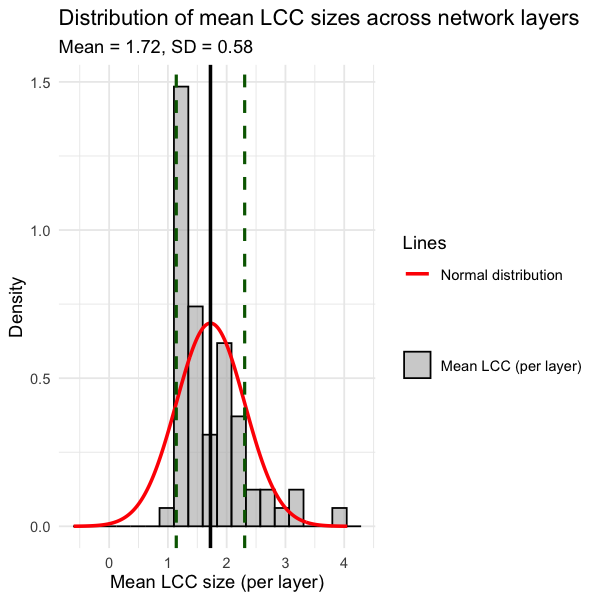

In [17]:
ggplot(data.frame(mean_lcc = mean_lcc_vec),
       aes(x = mean_lcc)) +

  # histogram mean LCC
  geom_histogram(
    aes(y = after_stat(density), fill = "Mean LCC (per layer)"),
    bins = 20,
    color = "black",
    alpha = 0.6
  ) +

  # normalditribution
  geom_line(
    data = norm_df_means,
    aes(x = x, y = y, color = "Normal distribution"),
    linewidth = 1
  ) +

  # mean
  geom_vline(
    xintercept = mu_means,
    color = "black",
    linewidth = 1
  ) +

  # ±1 SD
  geom_vline(
    xintercept = c(mu_means - sd_means, mu_means + sd_means),
    linetype = "dashed",
    color = "darkgreen",
    linewidth = 0.9
  ) +

  scale_fill_manual(
    name = "",
    values = c("Mean LCC (per layer)" = "grey70")
  ) +

  scale_color_manual(
    name = "Lines",
    values = c("Normal distribution" = "red")
  ) +

  theme_minimal() +
  labs(
    x = "Mean LCC size (per layer)",
    y = "Density",
    title = "Distribution of mean LCC sizes across network layers",
    subtitle = paste0(
      "Mean = ", round(mu_means, 2),
      ", SD = ", round(sd_means, 2)
    )
  )


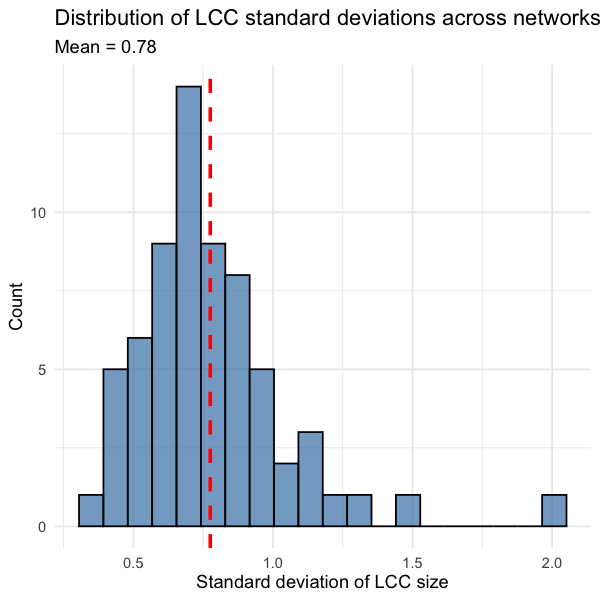

In [18]:
# distribution of the standard deviations

ggplot(df, aes(x = sd_lcc)) +
  geom_histogram(bins = 20, fill = "steelblue", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean(sd_lcc)), 
             color = "red", linetype = "dashed", linewidth = 1) +
  theme_minimal() +
  labs(
    x = "Standard deviation of LCC size",
    y = "Count",
    title = "Distribution of LCC standard deviations across networks",
    subtitle = paste("Mean =", round(mean(df$sd_lcc), 2))
  )
  ggsave(
  "results/dist_sd_LCC.pdf",
  width = 5,
  height = 5
)

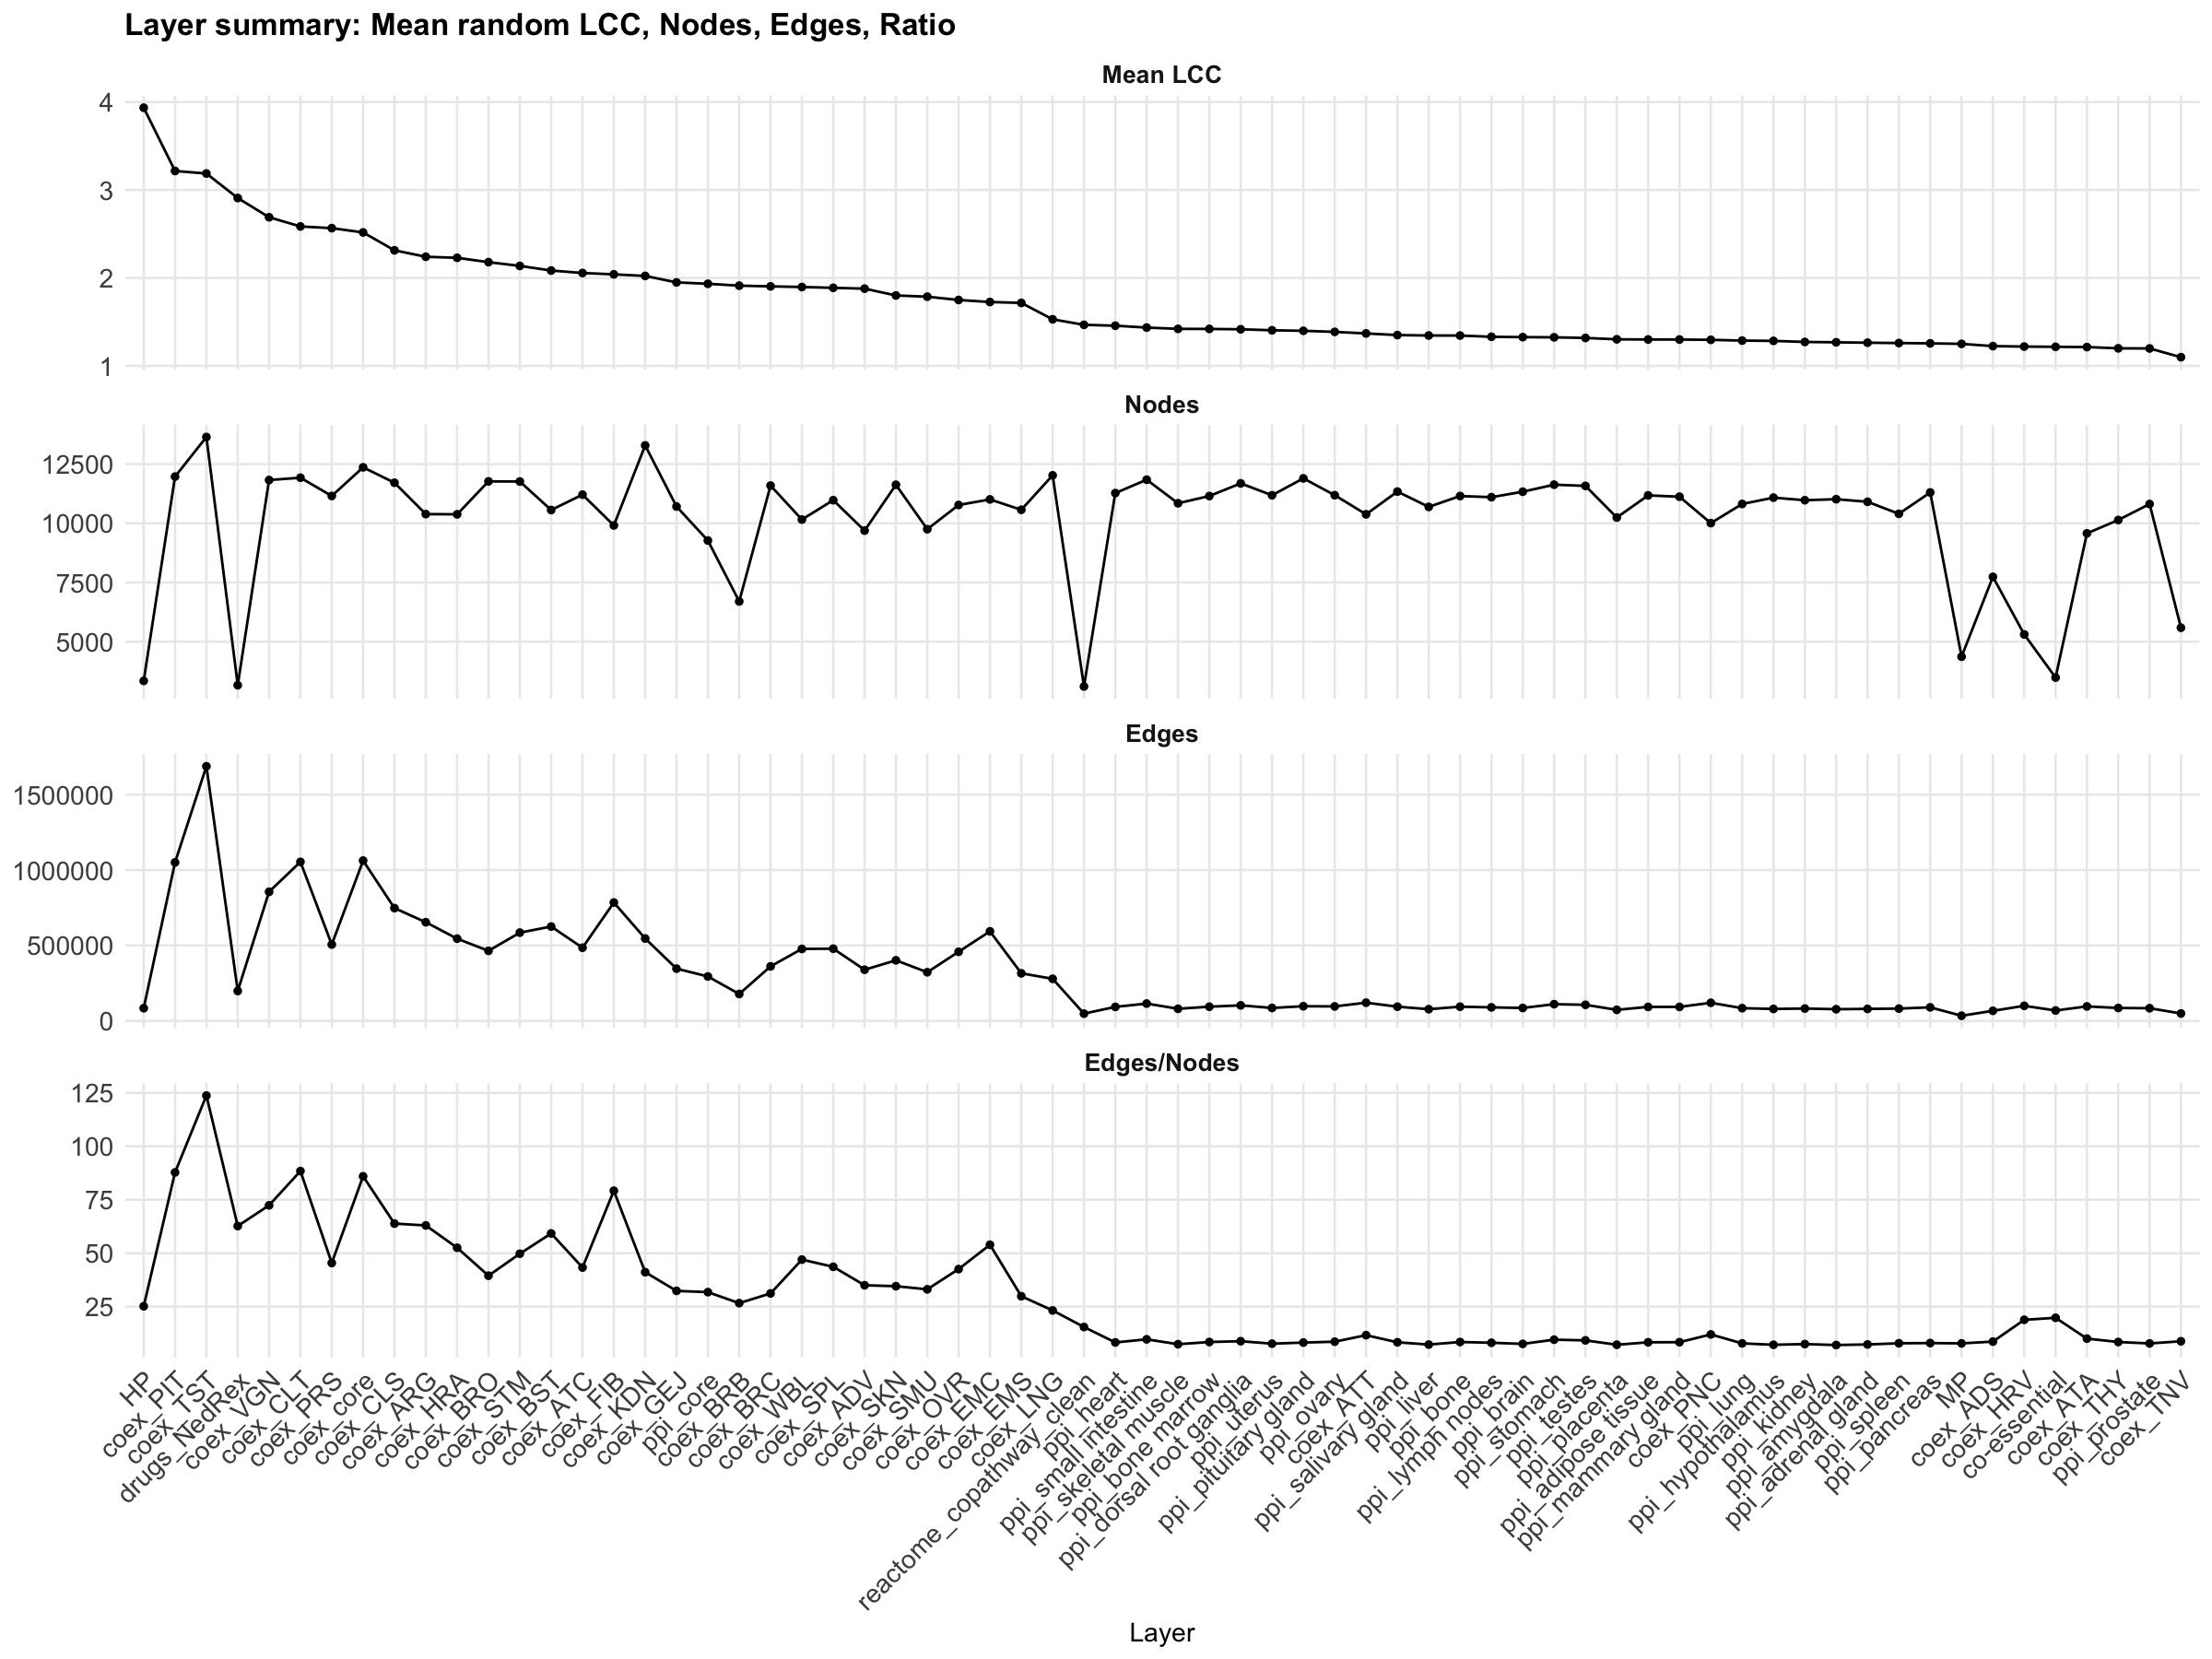

In [21]:
options(repr.plot.width=20, repr.plot.height=15)
# layer summary plot: mean LCC, nodes, edges, ratio

# extract number of nodes, number of edges and calculate edge/node Ratio per layer
layer_stats <- data.frame(
  layer = names(graph_list),
  nodes = sapply(graph_list, vcount),
  edges = sapply(graph_list, ecount)
) %>%
  mutate(edge_node_ratio = edges / nodes)

# merge information of mean LCC fom null model to dataframe 
layer_stats <- layer_stats %>%
  left_join(df %>% transmute(layer = network_name, mean_lcc_size),
            by = "layer")

# sort df by mean LCC size
layer_stats <- layer_stats %>%
  arrange(desc(mean_lcc_size)) %>%
  mutate(layer = factor(layer, levels = layer))

# long-format for plotting
plot_df <- layer_stats %>%
  pivot_longer(
    cols = c(mean_lcc_size, nodes, edges, edge_node_ratio),
    names_to = "metric",
    values_to = "value"
  ) %>%
  mutate(metric = factor(
    metric,
    levels = c("mean_lcc_size","nodes","edges","edge_node_ratio"),
    labels = c("Mean LCC","Nodes","Edges","Edges/Nodes")
  ))
# plot all metrics in one figure
p_all <- ggplot(plot_df, aes(x = layer, y = value, group = 1)) +
  geom_line(linewidth = 0.8) +
  geom_point(size = 2) +
  facet_wrap(~ metric, scales = "free_y", ncol = 1) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(size = 20, face = "bold"),
    strip.text = element_text(size = 16, face = "bold"),
    axis.title.x = element_text(size = 17),
    axis.text.x = element_text(size = 17, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 17),
    panel.grid.minor = element_blank()
  ) +
  labs(
    x = "Layer",
    y = NULL,
    title = "Layer summary: Mean random LCC, Nodes, Edges, Ratio"
  )

p_all


ggsave("results/layer_summary_all_metrics.pdf", p_all, width = 20, height = 10, dpi = 300)
